In [1]:
import numpy as np
from SimPEG import *
import SeogiUtils as SeUtils
import simpegEM.Utils.Solver.Mumps as Mumps
from simpegPF import MagAnalytics
from SeogiUtils.Optimize import ProjectedGNCG
% pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    


ImportError: No module named SeogiUtils

In [2]:
cs, ncx, ncy, ncz, npad = 20., 31, 31, 1, 0
hx = [(cs,npad,-1.3), (cs,ncx), (cs,npad,1.3)]
hy = [(cs,npad,-1.3), (cs,ncy), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.TensorMesh([hx,hy,hz], 'CCC')

In [3]:
sph_ind = MagAnalytics.spheremodel(mesh, 0., 0., -200, 200)
model = np.zeros(mesh.nC)
model[sph_ind] = 10.

NameError: name 'MagAnalytics' is not defined

In [902]:
from simpegEM import Sources

In [903]:
txloc = np.ones((1,3))
txloc[0,0] = 0.
txloc[0,1] = 0.
txloc[0,2] = 0.

In [904]:
xr =  np.arange(-125., 126., 25.)
nrx_x = xr.size
yr =  np.arange(-125., 126., 25.)
nrx_y = yr.size
xyz_tx = Utils.ndgrid(xr, yr, np.r_[0.])

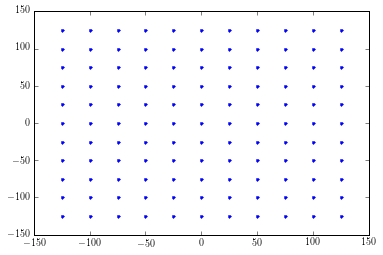

In [905]:
plt.plot(xyz_tx[:,0], xyz_tx[:,1], '.')

In [906]:
ax = Sources.MagneticLoopVectorPotential(txloc, mesh.gridEx, 'x', 200.)
ay = Sources.MagneticLoopVectorPotential(txloc, mesh.gridEy, 'y', 200.)
az = Sources.MagneticLoopVectorPotential(txloc, mesh.gridEz, 'z', 200.)

In [907]:
a = np.r_[ax, ay, az]

In [908]:
mesh.edgeCurl.shape

(3906, 4992)

In [909]:
a.shape

(4992,)

In [910]:
b = mesh.edgeCurl*a

In [911]:
P = mesh.getInterpolationMat(xyz_tx, 'Fz')

In [912]:
b_primary = P*b

In [913]:
X = xyz_tx[:,0].reshape((nrx_x, nrx_y), order='F')
Y = xyz_tx[:,1].reshape((nrx_x, nrx_y), order='F')
B_prim = b_primary.reshape((nrx_x, nrx_y), order='F')

In [914]:
Circ1 = SeUtils.View.Circle2D(np.r_[0.,0.], 200, 50)

In [915]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'text.usetex': True})

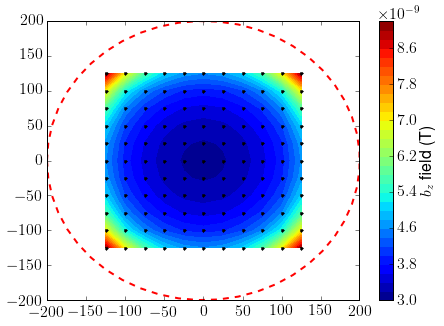

In [916]:
fig, ax = plt.subplots(1,1,figsize = (7,5))
dat1 = ax.contourf(X, Y, B_prim, 30)
ax.plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax.plot(xyz_tx[:,0], xyz_tx[:,1], 'k.')
cb = plt.colorbar(dat1)
cb.set_label("$b_z$ field (T)")
fig.savefig("/home/seogi/Google Drive/Ideas/obs.png", dpi=100)

In [918]:
ntx = xyz_tx.shape[0]

In [919]:
G = SeUtils.BiotSavart.BiotSavartFun(mesh, xyz_tx, component = 'z')

In [920]:
from SimPEG.Maps import IdentityMap
class VecMap(IdentityMap):
    @property
    def nP(self):
        return self.mesh.nC*3

In [921]:
# O = Utils.spzeros(mesh.nC, mesh.nC)
# J = G*sp.vstack((Utils.speye(mesh.nC), O, O))

In [922]:
# active = mesh.gridCC[:,2]<0.
# actMap = Maps.ActiveCells(mesh, active, 0.)
# mapping = actMap
mapping = VecMap(mesh)

In [923]:
prb = SeUtils.LinearIP.LinearProblem(mesh, mapping)
prb.J = G
prb.Solver = Utils.SolverUtils.SolverWrapD(Mumps, factorize=True)
survey = SeUtils.LinearIP.AirbornSurvey()
prb.unpair()
prb.pair(survey)

In [924]:
# dtrue = survey.dpred(ones(mesh.nC*3))
dtrue = b_primary

In [925]:
# fig, ax = plt.subplots(1,2, figsize = (15, 5))
# X = xyz_tx[:,0].reshape(nrx_x, nrx_y, order = 'F')
# Y = xyz_tx[:,1].reshape(nrx_x, nrx_y, order = 'F')
# Dtrue = dtrue.reshape(nrx_x, nrx_y, order = 'F')
# dat1 = ax[0].contourf(X, Y, Dtrue, 30)
# dat2 = ax[1].contourf(X, Y, Dtrue, 30)
# plt.colorbar(dat1, ax = ax[0])
# plt.colorbar(dat2, ax = ax[1])

In [926]:
# plt.pcolor(dtrue.reshape((nrx_x, nrx_y), order='F'))

In [927]:
survey.dtrue = dtrue
std = 0.05
noise = std*abs(survey.dtrue)*np.random.randn(*survey.dtrue.shape)
survey.dobs = survey.dtrue+noise
survey.std = survey.dobs*0 + std

In [984]:
dmisfit = DataMisfit.l2_DataMisfit(survey)
# dmisfit.Wd = 1./(np.ones(survey.dobs.size)*abs(np.max(survey.dobs)))
dmisfit.Wd = 1./(np.ones(survey.dobs.size)*abs(survey.dobs)+1e-9)

In [929]:
m0 = np.zeros(mesh.nC*3)

In [1190]:
class SparseRegularization(Regularization.BaseRegularization):
    
    perturbation0 = None
    perturbation = None
    rate = None
    m_before = None
    Wm = None
    Rm = None
    alpha = None
    alpha_before = None
    phim_before = None
    p = 0.
    vec_store = []
    
    def __init__(self, mesh, mapping=None, **kwargs):
        Regularization.BaseRegularization.__init__(self, mesh, mapping=mapping, **kwargs)
        
    
    def W(self):
        """Full regularization weighting matrix W."""
        iteration = self.opt.iter
        dec = (self.rate)**iteration
        self.Rm = self.R(self.m_before, dec)
#         print ("dec = %5e")%(dec)
        return self.Rm*sp.identity(self.mapping.nP)
    
    def R(self, m, dec):

        self.perturbation = self.perturbation0*dec
        R = Utils.sdiag( 1./ ((self.mapping *(m**2+self.perturbation**2)**(1-self.p/2) ) )**0.5 )
        return R

    @Utils.timeIt
    def eval(self, m):
        r = self.Wm * ( self.mapping * (m) )
        return 0.5*r.dot(r)*self.alpha

    @Utils.timeIt
    def evalDeriv(self, m):
        mD = self.mapping.deriv(m)
        r = self.Wm * ( self.mapping * (m) )
        return  mD.T * ( self.Wm.T * r )*self.alpha

    @Utils.timeIt
    def eval2Deriv(self, m, v=None):
        
        if self.m_before == None:
            self.m_before = m        
        
        self.Wm = self.W()
        rm = self.Rm.dot(self.m_before)
        
        if  self.opt.iter==0:
            self.alpha = m.dot(m)/(rm.dot(rm))
        else:
            self.alpha = self.phim_before/(rm.dot(rm))
        
        self.phim_before = (rm.dot(rm))*self.alpha
        self.m_before = m
        mD = self.mapping.deriv(m)
        self.vec_store.append(self.Rm.T*(self.Rm*m))
        print ("alpha= %5e, peturb= %5e")%(self.alpha, self.perturbation)
        if v is None:
            return mD.T * self.Wm.T * self.Wm * mD*self.alpha
        return mD.T * ( self.Wm.T * ( self.Wm * ( mD * v) ) )*self.alpha

(array([  2.05600000e+03,   4.99000000e+02,   1.55000000e+02,
          6.10000000e+01,   5.90000000e+01,   1.00000000e+00,
          8.00000000e+00,   1.70000000e+01,   1.90000000e+01,
          8.00000000e+00]),
 array([  0.00000000e+00,   6.42532598e-05,   1.28506520e-04,
          1.92759779e-04,   2.57013039e-04,   3.21266299e-04,
          3.85519559e-04,   4.49772819e-04,   5.14026079e-04,
          5.78279338e-04,   6.42532598e-04]),
 <a list of 10 Patch objects>)

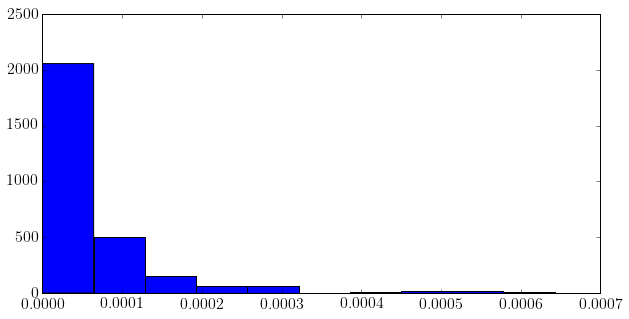

In [1194]:
figsize(10, 5)
hist(abs(mopt_l2))

In [1356]:
reg0 = Regularization.BaseRegularization(mesh, mapping = mapping)
reg1 = SparseRegularization(mesh, mapping = mapping)
# reg1.rate = 0.5
# reg1.perturbation0 = 0.00065
reg1.rate = 0.8
reg1.perturbation0 = 0.0001

reg1.p = 0.
opt = Optimization.InexactGaussNewton(maxIter = 10, maxIterLS=15)

# opt = Optimization.ProjectedGNCG(maxIter = 15)
# opt = Optimization.ProjectedGradient(maxIter = 15)
# opt.lower = 0.
# invProb = InvProblem.BaseInvProblem(dmisfit, reg0, opt)

invProb = InvProblem.BaseInvProblem(dmisfit, reg1, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e-1)

# betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e-1)
# betaest = Directives.BetaSchedule(beta=)
# BetaEstimate_ByEig(beta0_ratio=1e-1)

inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest])
# reg.alpha_s = 1.
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
reg1.mref = 0.
prb.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [1357]:
mopt = inv.run(mopt_l2)
# mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
alpha= 5.424578e-08, peturb= 1.000000e-04
alpha= 5.424578e-08, peturb= 1.000000e-04
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.35e+04  1.11e-01  1.59e-05  3.26e-01    5.86e+02      0              
alpha= 5.424578e-08, peturb= 1.000000e-04
alpha= 5.424578e-08, peturb= 1.000000e-04
alpha= 5.424578e-08, peturb= 1.000000e-04
alpha= 5.424578e-08, peturb= 1.000000e-04
alpha= 5.424578e-08, peturb= 1.000000e-04
   1  1.35e+04  6.94e-03  1.62e-05  2.25e-01    5.19e+02      0              
alpha= 4.525803e-08, peturb= 8.000000e-05
alpha= 4.634058e-08, peturb= 8.000000e-05
alpha= 4.634058e-08, peturb= 8.000000e-05
alpha= 4.634058e-08, peturb= 8.000000e-05
alpha= 4.6340

In [1358]:
opt.counter.summary()
xc = opt.recall('xc')
# dpredall = [survey.dpred(xc_i) for xc_i in xc]

Counters:
  InexactGaussNewton.doEndIteration       :        3
  InexactGaussNewton.doStartIteration     :        4
  InexactGaussNewton.modifySearchDirectionBreak:        1
  InexactGaussNewton.scaleSearchDirection :        4

Times:                                        mean      sum
  InexactGaussNewton.findSearchDirection  : 2.51e-02, 1.00e-01,    4x
  InexactGaussNewton.minimize             : 1.07e+01, 1.07e+01,    1x
  InexactGaussNewton.modifySearchDirection: 2.17e+00, 8.69e+00,    4x
  InexactGaussNewton.projection           : 5.83e-05, 1.81e-03,   31x
  LinearProblem.Jtvec_approx              : 5.19e-04, 1.09e-02,   21x
  LinearProblem.Jvec_approx               : 1.78e-04, 3.74e-03,   21x


In [1359]:
# plt.plot(np.sort(abs(reg1.vec_store[1])), '.')

In [1360]:
# plot(abs(mopt))
# iteration = 2
# mopt = xc[iteration]

In [1380]:
mopt_sort = np.sort(mopt)
ind = np.argsort(mopt)

In [1387]:
rm = abs(reg1.Rm.T*(reg1.Rm*mopt))

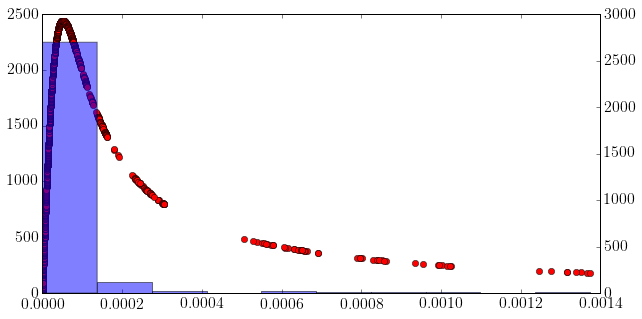

In [1399]:
fig = plt.figure()
ax = plt.subplot(111)
ax1 = plt.twinx()
ax1.hist(abs(mopt), alpha = 0.5)
ax.plot(abs(mopt[ind]), abs(rm[ind])/4, 'ro', lw=2)

In [1400]:
# xc = opt.recall('xc')
# opt.iter

In [1401]:
# fig, ax = plt.subplots(1,2, figsize = (15, 3))
# dat1 = mesh.plotSlice(mx, normal = 'X', ax = ax[0])
# cb = colorbar(dat1[0], ax = ax[0])
# dat2 = mesh.plotSlice(mx, normal = 'X', ax = ax[1])
# cb = colorbar(dat2[0], ax = ax[1])
# # ax[0].set_ylim(-600., 0.)
# # ax[1].set_ylim(-600., 0.)

In [1402]:

area = 20**2
# mx = xc[iteration].reshape((mesh.nC, 3), order='F')[:,0] * area
# my = xc[iteration].reshape((mesh.nC, 3), order='F')[:,1] * area
# mz = xc[iteration].reshape((mesh.nC, 3), order='F')[:,2] * area
mx = mopt.reshape((mesh.nC, 3), order='F')[:,0] * area
my = mopt.reshape((mesh.nC, 3), order='F')[:,1] * area
mz = mopt.reshape((mesh.nC, 3), order='F')[:,2] * area

mx_l2 = mopt_l2.reshape((mesh.nC, 3), order='F')[:,0] * area
my_l2 = mopt_l2.reshape((mesh.nC, 3), order='F')[:,1] * area
mz_l2 = mopt_l2.reshape((mesh.nC, 3), order='F')[:,2] * area


xy = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
Xxy = xy[:,0].reshape((mesh.vnC[:2]), order='F')
Yxy = xy[:,1].reshape((mesh.vnC[:2]), order='F')
Mx = mx.reshape((mesh.vnC[:2]), order='F')
My = my.reshape((mesh.vnC[:2]), order='F')
Mx_l2 = mx_l2.reshape((mesh.vnC[:2]), order='F')
My_l2 = my_l2.reshape((mesh.vnC[:2]), order='F')

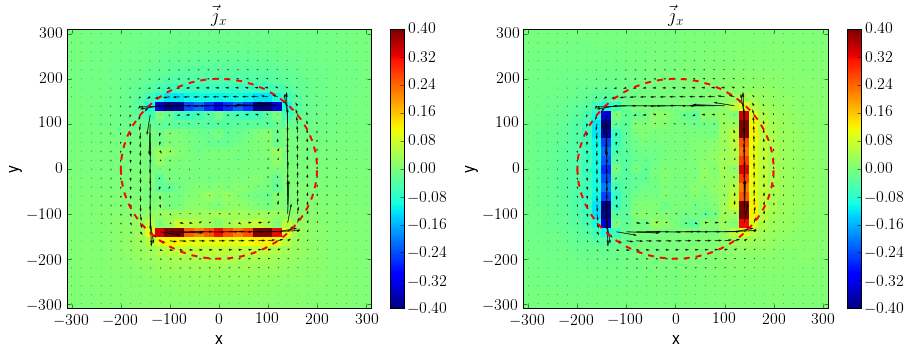

In [1403]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
dat1 = mesh.plotSlice(mx, normal = 'Z', ax = ax[0], ind = 0, clim = (-0.4, 0.4))
ax[0].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[0].quiver(Xxy, Yxy, Mx, My, scale=5)
cb = colorbar(dat1[0], ax = ax[0])
dat2 = mesh.plotSlice(my, normal = 'Z', ax = ax[1], ind = 0, clim = (-0.4, 0.4))
cb = colorbar(dat2[0], ax = ax[1])
ax[1].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[1].quiver(Xxy, Yxy, Mx, My, scale=5)

ax[0].set_title("$\\vec{j}_x$")
ax[1].set_title("$\\vec{j}_x$")
fig.savefig("/home/seogi/Google Drive/Ideas/recovered_j.png", dpi=100)

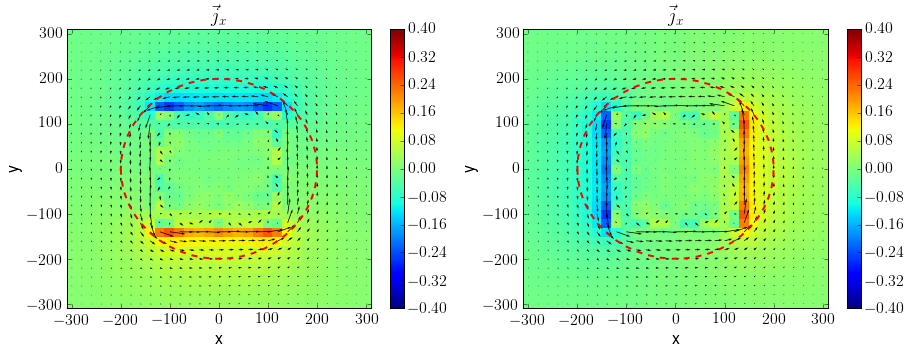

In [1404]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
dat1 = mesh.plotSlice(mx_l2, normal = 'Z', ax = ax[0], ind = 0, clim = (-0.4, 0.4))
ax[0].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[0].quiver(Xxy, Yxy, Mx_l2, My_l2, scale=5)
cb = colorbar(dat1[0], ax = ax[0])
dat2 = mesh.plotSlice(my_l2, normal = 'Z', ax = ax[1], ind = 0, clim = (-0.4, 0.4))
cb = colorbar(dat2[0], ax = ax[1])
ax[1].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[1].quiver(Xxy, Yxy, Mx_l2, My_l2, scale=5)

ax[0].set_title("$\\vec{j}_x$")
ax[1].set_title("$\\vec{j}_x$")
# fig.savefig("/home/seogi/Google Drive/Ideas/recovered_j.png", dpi=100)

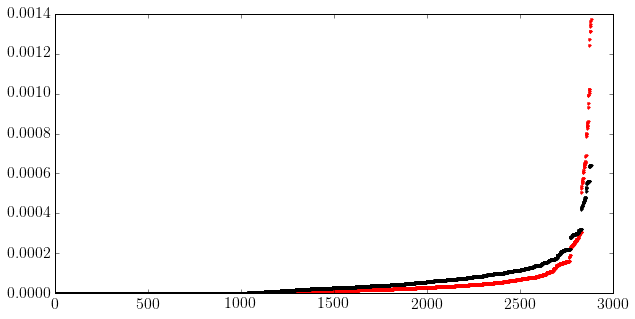

In [1405]:
plt.plot(np.sort(abs(mopt)), 'r.')
plt.plot(np.sort(abs(mopt_l2)), 'k.')

In [1406]:
np.median(abs(mx))

0.010629142125980437

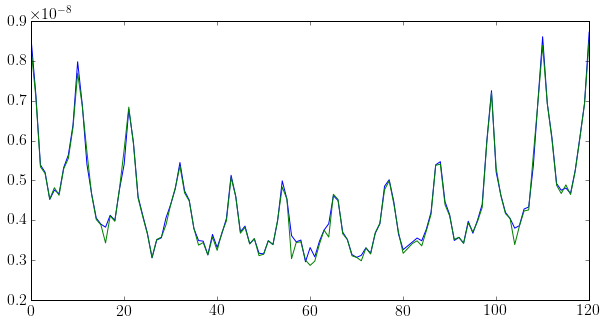

In [1407]:
plt.plot(survey.dobs)
plt.plot(invProb.dpred)

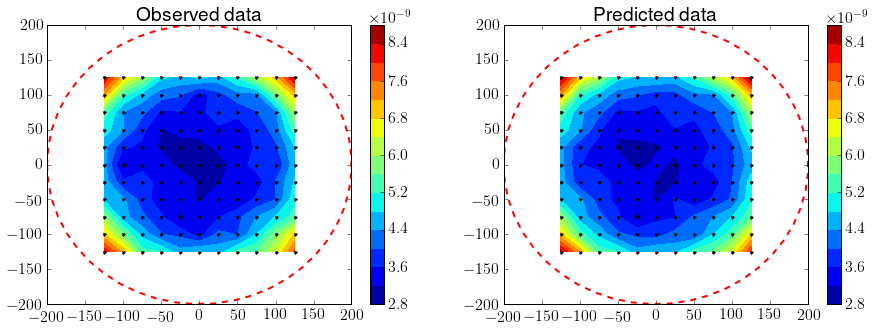

In [1408]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
dat1 = ax[0].contourf(X, Y, invProb.dpred.reshape((nrx_x, nrx_y), order='F'), 15)
ax[0].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[0].plot(xyz_tx[:,0], xyz_tx[:,1], 'k.')
cb = colorbar(dat1, ax = ax[0])
dat2 = ax[1].contourf(X, Y, survey.dobs.reshape((nrx_x, nrx_y), order='F'), 15)

cb = colorbar(dat2, ax = ax[1])
ax[1].plot(Circ1[:,0], Circ1[:,1], 'r--', lw = 2)
ax[1].plot(xyz_tx[:,0], xyz_tx[:,1], 'k.')

ax[0].set_title("Observed data")
ax[1].set_title("Predicted data")
fig.savefig("/home/seogi/Google Drive/Ideas/obspred_bz.png", dpi=100)

In [1409]:
Utils.meshutils.writeUBCTensorModel("/home/seogi/Google Drive/Ideas/mx.j", mesh, mx)
Utils.meshutils.writeUBCTensorModel("/home/seogi/Google Drive/Ideas/my.j", mesh, my)
Utils.meshutils.writeUBCTensorModel("/home/seogi/Google Drive/Ideas/mz.j", mesh, mz)
Utils.meshutils.writeUBCTensorMesh("/home/seogi/Google Drive/Ideas/mesh.msh", mesh)

In [1410]:
tempx = np.loadtxt("/home/seogi/Google Drive/Ideas/mx.j")
tempy = np.loadtxt("/home/seogi/Google Drive/Ideas/my.j")
tempz = np.loadtxt("/home/seogi/Google Drive/Ideas/mz.j")
np.savetxt("/home/seogi/Google Drive/Ideas/mxyz.j", np.c_[tempx, tempy, tempz])
np.savetxt("/home/seogi/Google Drive/Ideas/txloc.txt", np.hstack((Circ1, np.ones((Circ1.shape[0],1)))))